In [1]:
import pandas as pd
from readability import Readability
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datasets import load_dataset
import ast
import textstat

## Human Readability Metrics

In [ ]:
# get human completions
dolly = load_dataset("databricks/databricks-dolly-15k")["train"].filter(lambda row: row['category']=='creative_writing').to_pandas()
sample = pd.read_csv('../data/dolly_creative_prompts_sample.tsv', sep='\t')
sample['response'] = sample['index'].apply(lambda x: dolly.loc[x, 'response'])
sample['prompt_id'] = [i for i in range(len(sample))]
prompts = sample['instruction'].values.tolist()
human_responses = sample['response'].values.tolist()

Response too short: Caressed by sweet brine,
you are crispy and crunchy.
Oh, won’t you be mine?
Response too short: Both things weigh the same amount, one pound.


In [ ]:
# get flesch-kincaid and gunning-fog scores for human_responses
df_readability = pd.DataFrame(columns=["persona_id", "response", "fk_mean", "gf_mean", "fk_scores", "gf_scores", "fk_std", "gf_std"])
fk_scores = []
gf_scores = []
num_too_small_fk = 0
num_too_small_gf = 0
for response in human_responses:
    r = Readability(response)
    try:
        score_fk = textstat.flesch_kincaid_grade(response)
        # score = r.flesch_kincaid().score
        fk_scores.append(score_fk)
    except:
        print("need at least 100 words", len(response))
        num_too_small_fk += 1
    try:
        score_gf = textstat.gunning_fog(response)
        # score = r.gunning_fog().score
        gf_scores.append(score_gf)
    except:
        print("need at least 100 words", len(response))
        num_too_small_gf += 1
print(np.mean(fk_scores), np.mean(gf_scores))
# print(num_too_small_fk / len(human_responses), num_too_small_gf / len(human_responses))
df_readability.loc[len(df_readability)] = ["total", human_responses, np.mean(fk_scores), np.mean(gf_scores), fk_scores, gf_scores, 0, 0]
df_readability.to_csv("../output_readability/human_responses.csv", index=False)

10.601 12.309199999999999


## Deepseek Readability Metrics

In [ ]:
df = pd.read_csv("../output/coarse/deepseek-cutoff-persona/DeepSeek-V3_dolly_output.tsv", sep="\t")
df_readability = pd.DataFrame(columns=["persona_id", "response", "fk_mean", "gf_mean", "fk_scores", "gf_scores", "fk_std", "gf_std"])
df_grouped = df.groupby(["persona_id"]).agg({"prompt_id": lambda x: list(x), "response": lambda x: list(x)}).reset_index()
for i, row in df_grouped.iterrows():
    responses = row['response']
    fk_scores = []
    gf_scores = []
    for response in responses:
        score_fk = textstat.flesch_kincaid_grade(response)
        fk_scores.append(score_fk)
        score_gf = textstat.gunning_fog(response)
        gf_scores.append(score_gf)
    df_readability.loc[len(df_readability)] = [row['persona_id'], row['response'], np.mean(fk_scores), np.mean(gf_scores), fk_scores, gf_scores, np.std(fk_scores), np.std(gf_scores)]
total_mean_fk = np.mean(df_readability['fk_mean'])
total_mean_gf = np.mean(df_readability['gf_mean'])
total_std_fk = np.std(df_readability['fk_mean'])
total_std_gf = np.std(df_readability['gf_mean'])
df_readability.loc[len(df_readability)] = ["total", None, total_mean_fk, total_mean_gf, None, None, total_std_fk, total_std_gf]
print(total_mean_fk, total_mean_gf)
print(total_std_fk, total_std_gf)
df_readability.to_csv("../output_readability/deepseek-np-full.csv", index=False)


9.139037878787878 10.707560808080807
1.8239285134142336 2.0222784743651916


                          setting    fk_mean    gf_mean    fk_std    gf_std
0                 human_responses  10.601000  12.309200  0.000000  0.000000
1  deepseek-persona-cutoff-coarse   9.139038  10.707561  1.823929  2.022278
2         deepseek-persona-cutoff   9.189160  10.765267  2.175569  2.379918
3              deepseek-np-cutoff   9.473000  10.877700  0.000000  0.000000
4                deepseek-np-full   9.139038  10.707561  1.823929  2.022278


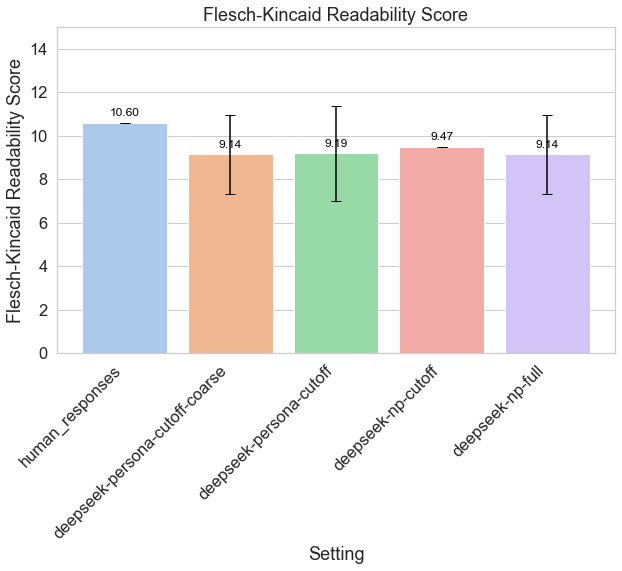

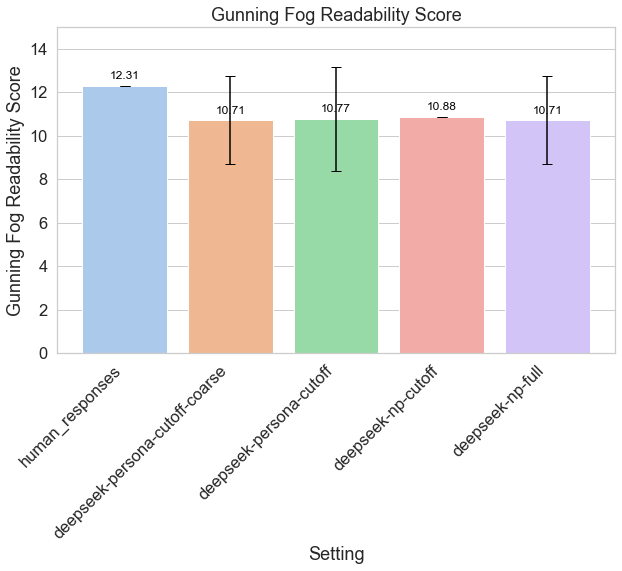

In [ ]:
# create bar plots of flesch-kincaid and gunning-fog scores for deepseek and human responses
df_bar = pd.DataFrame(columns=["setting", "fk_mean", "gf_mean", "fk_std", "gf_std"])
for file in ["../output_readability/human_responses.csv", 
              "../output_readability/deepseek-persona-cutoff-coarse.csv",
              "../output_readability/deepseek-persona-cutoff.csv",
              "../output_readability/deepseek-np-cutoff.csv",
              "../output_readability/deepseek-np-full.csv"]:
    df = pd.read_csv(file)
    # get row with index "total"
    total_row = df[df['persona_id'] == 'total']
    df_bar.loc[len(df_bar)] = [file.split("/")[-1].split(".")[0], total_row['fk_mean'].values[0], total_row['gf_mean'].values[0], total_row['fk_std'].values[0], total_row['gf_std'].values[0]]
print(df_bar)
# make bar plot of means with std as error bars
for metric in ["fk", "gf"]:
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    sns.set_context("notebook", font_scale=1.5)
    plt.figure(figsize=(10, 6))
    bar = sns.barplot(x="setting", y="{}_mean".format(metric), data=df_bar, palette="pastel", ci=None)
    if metric == "fk":
        bar.set_title("Flesch-Kincaid Readability Score")
        bar.set_ylabel("Flesch-Kincaid Readability Score") 
    else:
        bar.set_title("Gunning Fog Readability Score")
        bar.set_ylabel("Gunning Fog Readability Score") 
    bar.set_xlabel("Setting")
    bar.set_ylim(0, 15)
    # show mean and std on top of bars
    for p in bar.patches:
        bar.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')
    bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.errorbar(x=range(len(df_bar)), y=df_bar["{}_mean".format(metric)], yerr=df_bar["{}_std".format(metric)], fmt='none', c='black', capsize=5)
    plt.savefig("../output_readability/{}.png".format(metric), bbox_inches='tight')
    plt.show()


In [13]:
# make violin plots of persona-coarse and persona
df_persona_coarse = pd.read_csv("../output_readability/deepseek-persona-cutoff-coarse.csv")
df_persona = pd.read_csv("../output_readability/deepseek-persona-cutoff.csv")
df_persona_coarse = df_persona_coarse[df_persona_coarse['persona_id'] != 'total']
df_persona = df_persona[df_persona['persona_id'] != 'total']
for metric in ["fk", "gf"]:
    coarse_values = df_persona_coarse['{}_mean'.format(metric)].values.tolist()
    fine_values = df_persona['{}_mean'.format(metric)].values.tolist()
    # create a violin plot
    fig = go.Figure()
    fig.add_trace(go.Violin(y=coarse_values, name='Coarse', box_visible=True, line_color='blue', fillcolor='rgba(0, 0, 255, 0.5)', opacity=0.6))
    fig.add_trace(go.Violin(y=fine_values, name='Fine', box_visible=True, line_color='orange', fillcolor='rgba(255, 165, 0, 0.5)', opacity=0.6))
    if metric == "fk":
        fig.update_layout(title='Flesch-Kincaid Readability Score', yaxis_title='Flesch-Kincaid Score', xaxis_title='Setting', width=800, height=600)
    else:
        fig.update_layout(title='Gunning Fog Readability Score', yaxis_title='Gunning Fog Score', xaxis_title='Setting', width=800, height=600)
    fig.show()

## Llama Readability Metrics

In [10]:
df = pd.read_csv("../output/llama-temp0.7/llama70b-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv", sep="\t")
df_readability = pd.DataFrame(columns=["persona_id", "response", "fk_mean", "gf_mean", "fk_scores", "gf_scores", "fk_std", "gf_std"])
df_grouped = df.groupby(["persona_id"]).agg({"prompt_id": lambda x: list(x), "response": lambda x: list(x)}).reset_index()
for i, row in df_grouped.iterrows():
    responses = row['response']
    fk_scores = []
    gf_scores = []
    for response in responses:
        score_fk = textstat.flesch_kincaid_grade(response)
        fk_scores.append(score_fk)
        score_gf = textstat.gunning_fog(response)
        gf_scores.append(score_gf)
    df_readability.loc[len(df_readability)] = [row['persona_id'], row['response'], np.mean(fk_scores), np.mean(gf_scores), fk_scores, gf_scores, np.std(fk_scores), np.std(gf_scores)]
total_mean_fk = np.mean(df_readability['fk_mean'])
total_mean_gf = np.mean(df_readability['gf_mean'])
total_std_fk = np.std(df_readability['fk_mean'])
total_std_gf = np.std(df_readability['gf_mean'])
df_readability.loc[len(df_readability)] = ["total", None, total_mean_fk, total_mean_gf, None, None, total_std_fk, total_std_gf]
print(total_mean_fk, total_mean_gf)
print(total_std_fk, total_std_gf)
# df_readability.to_csv("../output_readability/llama70b-persona-cutoff-coarse.csv", index=False)

11.121965964912281 12.631063333333332
2.4595677138964347 2.2936402579524104


                          setting    fk_mean    gf_mean    fk_std    gf_std
0                 human_responses  10.601000  12.309200  0.000000  0.000000
1  llama70b-persona-cutoff-coarse   9.848720  11.860104  2.188772  2.319840
2         llama70b-persona-cutoff   9.948170  11.976315  2.313576  2.420398
3           llama70b-persona-full  11.121966  12.631063  2.459568  2.293640
4              llama70b-np-cutoff  11.843000  13.727400  0.000000  0.000000
5                llama70b-np-full  12.957000  14.082300  0.000000  0.000000


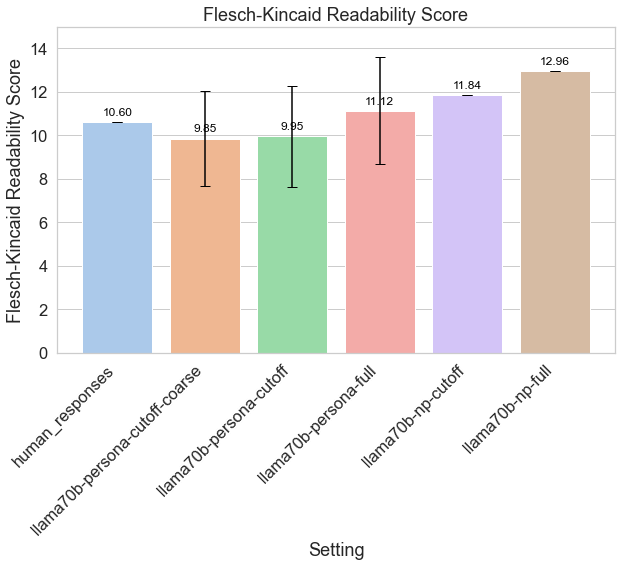

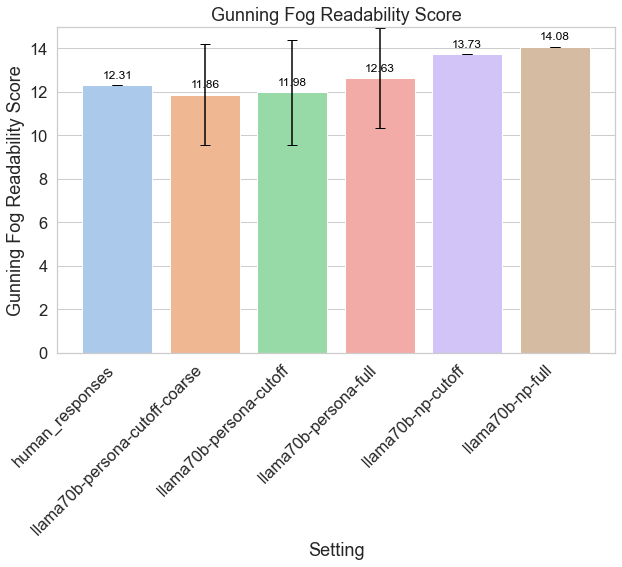

In [8]:
# create bar plots of flesch-kincaid and gunning-fog scores for deepseek and human responses
df_bar = pd.DataFrame(columns=["setting", "fk_mean", "gf_mean", "fk_std", "gf_std"])
for file in ["../output_readability/human_responses.csv", 
              "../output_readability/llama70b-persona-cutoff-coarse.csv",
              "../output_readability/llama70b-persona-cutoff.csv",
              "../output_readability/llama70b-persona-full.csv",
              "../output_readability/llama70b-np-cutoff.csv",
              "../output_readability/llama70b-np-full.csv"]:
    df = pd.read_csv(file)
    # get row with index "total"
    total_row = df[df['persona_id'] == 'total']
    df_bar.loc[len(df_bar)] = [file.split("/")[-1].split(".")[0], total_row['fk_mean'].values[0], total_row['gf_mean'].values[0], total_row['fk_std'].values[0], total_row['gf_std'].values[0]]
print(df_bar)
# make bar plot of means with std as error bars
for metric in ["fk", "gf"]:
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    sns.set_context("notebook", font_scale=1.5)
    plt.figure(figsize=(10, 6))
    bar = sns.barplot(x="setting", y="{}_mean".format(metric), data=df_bar, palette="pastel", ci=None)
    if metric == "fk":
        bar.set_title("Flesch-Kincaid Readability Score")
        bar.set_ylabel("Flesch-Kincaid Readability Score") 
    else:
        bar.set_title("Gunning Fog Readability Score")
        bar.set_ylabel("Gunning Fog Readability Score") 
    bar.set_xlabel("Setting")
    bar.set_ylim(0, 15)
    # show mean and std on top of bars
    for p in bar.patches:
        bar.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')
    bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.errorbar(x=range(len(df_bar)), y=df_bar["{}_mean".format(metric)], yerr=df_bar["{}_std".format(metric)], fmt='none', c='black', capsize=5)
    # plt.savefig("../output_readability/{}.png".format(metric), bbox_inches='tight')
    plt.show()